In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, brier_score_loss, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [17]:
!pip install gdown

In [18]:
def load_and_preprocess_data(url):
    !gdown https://drive.google.com/uc?id={url} -O "url.csv"
    data = pd.read_csv("url.csv")

    # Print the column names to check for any discrepancies
    print("Columns in the dataset:", data.columns)

    # Select relevant columns for the new dataset
    selected_columns = ['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
                        'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ',
                        'WHEEZING', 'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
                        'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER']

    # Ensure that all selected columns exist in the dataset
    missing_columns = [col for col in selected_columns if col not in data.columns]
    if missing_columns:
        print(f"Warning: The following columns are missing: {missing_columns}")
        # Optionally, remove missing columns from the selected_columns list
        selected_columns = [col for col in selected_columns if col in data.columns]

    data = data[selected_columns]

    # Map target 'LUNG_CANCER' to binary (Yes = 1, No = 0)
    data['LUNG_CANCER'] = data['LUNG_CANCER'].map({'YES': 1, 'NO': 0})

    # Encode categorical columns (e.g., 'GENDER', 'SMOKING', etc.)
    label_encoder = LabelEncoder()
    categorical_columns = ['GENDER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
                           'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING', 'ALCOHOL CONSUMING',
                           'COUGHING', 'SHORTNESS OF BREATH', 'SWALLOWING DIFFICULTY', 'CHEST PAIN']

    for column in categorical_columns:
        data[column] = label_encoder.fit_transform(data[column])

    return data

In [19]:
def calculate_metrics(conf_matrix, y_true=None, y_prob=None):
    """Calculate evaluation metrics."""
    TP, TN, FP, FN = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = sensitivity
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    balanced_accuracy = (sensitivity + specificity) / 2
    tss = sensitivity + specificity - 1
    hss_num = 2 * (TP * TN - FP * FN)
    hss_denom = (TP + FN) * (FP + TN) + (TP + FP) * (FN + TN)
    hss = hss_num / hss_denom if hss_denom else 0
    bs = np.mean((y_true - y_prob) ** 2) if y_true is not None and y_prob is not None else None
    bss_denom = np.mean((y_true - np.mean(y_true)) ** 2) if y_true is not None else None
    bss = 1 - (bs / bss_denom) if bs is not None and bss_denom else None
    return {
        'Sensitivity': sensitivity, 'Specificity': specificity, 'Accuracy': accuracy,
        'Precision': precision, 'Recall': recall, 'F1 Score': f1,
        'Balanced Accuracy': balanced_accuracy, 'TSS': tss, 'HSS': hss,
        'Brier Score': bs, 'Brier Skill Score': bss
    }

In [20]:
def train_model(model, X_train, y_train, X_test, y_test):
    """Train and evaluate a model."""
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, predictions)
    metrics = calculate_metrics(conf_matrix)
    auc = roc_auc_score(y_test, predictions)
    brier = brier_score_loss(y_test, predictions)
    return metrics, auc, brier

def build_lstm_model(input_shape):
    """Build an LSTM model."""
    model = Sequential([
        LSTM(50, input_shape=input_shape),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# Load and preprocess the dataset
dataset_url = '1EbM9lKDB8f_PegVbKxsNmBaTzpRikksz'
data = load_and_preprocess_data(dataset_url)

# Separate features and target
X, y = data.drop(columns=['LUNG_CANCER']), data['LUNG_CANCER']

# Apply StandardScaler only to the numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_columns] = StandardScaler().fit_transform(X[numerical_columns])

X_scaled = X.dropna()
y = y.dropna()
y = y.reset_index(drop=True)  # Reset index of y
X_scaled = X_scaled.reset_index(drop=True)  # Reset index of X_scaled
y = y.squeeze()  # Converts DataFrame to Series if y is a DataFrame
X_scaled = X_scaled.to_numpy()  # Convert X_scaled to numpy array for proper slicing

# Handling any mismatch between X and y
if len(X_scaled) != len(y):
    # Randomly sample data to make the lengths equal
    diff = abs(len(X_scaled) - len(y))
    random_indices = np.random.choice(len(X_scaled), diff)
    X_scaled = np.concatenate([X_scaled, X_scaled[random_indices]], axis=0)
    y = np.concatenate([y, y[random_indices]])

# Check that X_scaled and y have the same number of samples
assert len(y) == len(X_scaled), "Mismatch in number of samples between X and y"

Downloading...
From: https://drive.google.com/uc?id=1EbM9lKDB8f_PegVbKxsNmBaTzpRikksz
To: /content/url.csv
100% 11.3k/11.3k [00:00<00:00, 21.6MB/s]
Columns in the dataset: Index(['GENDER', 'AGE', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY',
       'PEER_PRESSURE', 'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'],
      dtype='object')



Fold 1:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 0  0]
 [ 2 29]]
Random Forest Metrics: {'Sensitivity': 0.9354838709677419, 'Specificity': nan, 'Accuracy': 0.9354838709677419, 'Precision': 1.0, 'Recall': 0.9354838709677419, 'F1 Score': 0.9666666666666666, 'Balanced Accuracy': nan, 'TSS': nan, 'HSS': 0.0, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 0  0]
 [ 2 29]]
SVM Metrics: {'Sensitivity': 0.9354838709677419, 'Specificity': nan, 'Accuracy': 0.9354838709677419, 'Precision': 1.0, 'Recall': 0.9354838709677419, 'F1 Score': 0.9666666666666666, 'Balanced Accuracy': nan, 'TSS': nan, 'HSS': 0.0, 'Brier Score': None, 'Brier Skill Score': None}


<ipython-input-19-cc1885cfba1b>:5: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
<ipython-input-19-cc1885cfba1b>:5: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
LSTM Confusion Matrix:
[[ 0  0]
 [ 1 30]]
LSTM Metrics: {'Sensitivity': 0.967741935483871, 'Specificity': nan, 'Accuracy': 0.967741935483871, 'Precision': 1.0, 'Recall': 0.967741935483871, 'F1 Score': 0.9836065573770492, 'Balanced Accuracy': nan, 'TSS': nan, 'HSS': 0.0, 'Brier Score': None, 'Brier Skill Score': None}

Fold 2:
Missing values in y_train: 0
Missing values in y_test: 0


<ipython-input-19-cc1885cfba1b>:5: RuntimeWarning: invalid value encountered in scalar divide
  specificity = TN / (TN + FP)


Random Forest Confusion Matrix:
[[ 1  1]
 [ 0 29]]
Random Forest Metrics: {'Sensitivity': 1.0, 'Specificity': 0.5, 'Accuracy': 0.967741935483871, 'Precision': 0.9666666666666667, 'Recall': 1.0, 'F1 Score': 0.983050847457627, 'Balanced Accuracy': 0.75, 'TSS': 0.5, 'HSS': 0.6590909090909091, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 1  1]
 [ 0 29]]
SVM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.5, 'Accuracy': 0.967741935483871, 'Precision': 0.9666666666666667, 'Recall': 1.0, 'F1 Score': 0.983050847457627, 'Balanced Accuracy': 0.75, 'TSS': 0.5, 'HSS': 0.6590909090909091, 'Brier Score': None, 'Brier Skill Score': None}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
LSTM Confusion Matrix:
[[ 1  1]
 [ 0 29]]
LSTM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.5, 'Accuracy': 0.967741935483871, 'Precision': 0.9666666666666667, 'Recall': 1.0, 'F1 Score': 0.983050847457627, 'Balanced Accuracy': 0.75, 'TSS': 0.5, 'HSS': 0.6590909090909091, 'Brier Score': None, 'Brier Skill Score': None}

Fold 3:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 5  0]
 [ 0 26]]
Random Forest Metrics: {'Sensitivity': 1.0, 'Specificity': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'Balanced Accuracy': 1.0, 'TSS': 1.0, 'HSS': 1.0, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 3  2]
 [ 0 26]]
SVM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.6, 'Accuracy': 0.9354838709677419, 'Precision': 0.9285714285714286, 'Recall': 1.0, 'F1 Score': 0.962962962962963, 'Balanced Accuracy': 0.8, 'TSS': 0.6000000000000001, 'HSS': 0.7289719626168224, 'Brier S

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
LSTM Confusion Matrix:
[[ 5  0]
 [ 0 26]]
LSTM Metrics: {'Sensitivity': 1.0, 'Specificity': 1.0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1 Score': 1.0, 'Balanced Accuracy': 1.0, 'TSS': 1.0, 'HSS': 1.0, 'Brier Score': None, 'Brier Skill Score': None}

Fold 4:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 0  4]
 [ 1 26]]
Random Forest Metrics: {'Sensitivity': 0.9629629629629629, 'Specificity': 0.0, 'Accuracy': 0.8387096774193549, 'Precision': 0.8666666666666667, 'Recall': 0.9629629629629629, 'F1 Score': 0.912280701754386, 'Balanced Accuracy': 0.48148148148148145, 'TSS': -0.03703703703703709, 'HSS': -0.057971014492753624, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 1  3]
 [ 1 26]]
SVM Metrics: {'Sensitivity': 0.9629629629629629, 'Specificity': 0.25, 'Accuracy': 0.8709677419354839, 'Precision': 0.896551724137931, 'Recall': 0.9629629629629629, 'F1 Score': 0.928571428

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
LSTM Confusion Matrix:
[[ 2  2]
 [ 0 27]]
LSTM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.5, 'Accuracy': 0.9354838709677419, 'Precision': 0.9310344827586207, 'Recall': 1.0, 'F1 Score': 0.9642857142857143, 'Balanced Accuracy': 0.75, 'TSS': 0.5, 'HSS': 0.6506024096385542, 'Brier Score': None, 'Brier Skill Score': None}

Fold 5:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 1  2]
 [ 2 26]]
Random Forest Metrics: {'Sensitivity': 0.9285714285714286, 'Specificity': 0.3333333333333333, 'Accuracy': 0.8709677419354839, 'Precision': 0.9285714285714286, 'Recall': 0.9285714285714286, 'F1 Score': 0.9285714285714286, 'Balanced Accuracy': 0.6309523809523809, 'TSS': 0.26190476190476186, 'HSS': 0.2619047619047619, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 1  2]
 [ 2 26]]
SVM Metrics: {'Sensitivity': 0.9285714285714286, 'Specificity': 0.3333333333333333, 'Accuracy': 0.8709677419354839,

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
LSTM Confusion Matrix:
[[ 1  2]
 [ 2 26]]
LSTM Metrics: {'Sensitivity': 0.9285714285714286, 'Specificity': 0.3333333333333333, 'Accuracy': 0.8709677419354839, 'Precision': 0.9285714285714286, 'Recall': 0.9285714285714286, 'F1 Score': 0.9285714285714286, 'Balanced Accuracy': 0.6309523809523809, 'TSS': 0.26190476190476186, 'HSS': 0.2619047619047619, 'Brier Score': None, 'Brier Skill Score': None}

Fold 6:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 3  1]
 [ 0 27]]
Random Forest Metrics: {'Sensitivity': 1.0, 'Specificity': 0.75, 'Accuracy': 0.967741935483871, 'Precision': 0.9642857142857143, 'Recall': 1.0, 'F1 Score': 0.9818181818181818, 'Balanced Accuracy': 0.875, 'TSS': 0.75, 'HSS': 0.84375, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 3  1]
 [ 0 27]]
SVM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.75, 'Accuracy': 0.967741935483871, 'Precision': 0.9642857142857143, 'Reca

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
LSTM Confusion Matrix:
[[ 2  2]
 [ 0 27]]
LSTM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.5, 'Accuracy': 0.9354838709677419, 'Precision': 0.9310344827586207, 'Recall': 1.0, 'F1 Score': 0.9642857142857143, 'Balanced Accuracy': 0.75, 'TSS': 0.5, 'HSS': 0.6506024096385542, 'Brier Score': None, 'Brier Skill Score': None}

Fold 7:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 3  5]
 [ 0 23]]
Random Forest Metrics: {'Sensitivity': 1.0, 'Specificity': 0.375, 'Accuracy': 0.8387096774193549, 'Precision': 0.8214285714285714, 'Recall': 1.0, 'F1 Score': 0.9019607843137255, 'Balanced Accuracy': 0.6875, 'TSS': 0.375, 'HSS': 0.5149253731343284, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 3  5]
 [ 0 23]]
SVM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.375, 'Accuracy': 0.8387096774193549, 'Precision': 0.8214285714285714, 'Recall': 1.0, 'F1 Score': 0.9019607843137255, 'Balanced Accura

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
LSTM Confusion Matrix:
[[ 3  5]
 [ 0 23]]
LSTM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.375, 'Accuracy': 0.8387096774193549, 'Precision': 0.8214285714285714, 'Recall': 1.0, 'F1 Score': 0.9019607843137255, 'Balanced Accuracy': 0.6875, 'TSS': 0.375, 'HSS': 0.5149253731343284, 'Brier Score': None, 'Brier Skill Score': None}

Fold 8:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 3  4]
 [ 0 24]]
Random Forest Metrics: {'Sensitivity': 1.0, 'Specificity': 0.42857142857142855, 'Accuracy': 0.8709677419354839, 'Precision': 0.8571428571428571, 'Recall': 1.0, 'F1 Score': 0.923076923076923, 'Balanced Accuracy': 0.7142857142857143, 'TSS': 0.4285714285714286, 'HSS': 0.5714285714285714, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 2  5]
 [ 0 24]]
SVM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.2857142857142857, 'Accuracy': 0.8387096774193549, 'Precision': 0.8275862068965517, 'Recal

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
LSTM Confusion Matrix:
[[ 4  3]
 [ 0 24]]
LSTM Metrics: {'Sensitivity': 1.0, 'Specificity': 0.5714285714285714, 'Accuracy': 0.9032258064516129, 'Precision': 0.8888888888888888, 'Recall': 1.0, 'F1 Score': 0.9411764705882353, 'Balanced Accuracy': 0.7857142857142857, 'TSS': 0.5714285714285714, 'HSS': 0.6956521739130435, 'Brier Score': None, 'Brier Skill Score': None}

Fold 9:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 3  2]
 [ 2 24]]
Random Forest Metrics: {'Sensitivity': 0.9230769230769231, 'Specificity': 0.6, 'Accuracy': 0.8709677419354839, 'Precision': 0.9230769230769231, 'Recall': 0.9230769230769231, 'F1 Score': 0.9230769230769231, 'Balanced Accuracy': 0.7615384615384615, 'TSS': 0.523076923076923, 'HSS': 0.5230769230769231, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 3  2]
 [ 2 24]]
SVM Metrics: {'Sensitivity': 0.9230769230769231, 'Specificity': 0.6, 'Accuracy': 0.87096

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
LSTM Confusion Matrix:
[[ 2  3]
 [ 2 24]]
LSTM Metrics: {'Sensitivity': 0.9230769230769231, 'Specificity': 0.4, 'Accuracy': 0.8387096774193549, 'Precision': 0.8888888888888888, 'Recall': 0.9230769230769231, 'F1 Score': 0.9056603773584906, 'Balanced Accuracy': 0.6615384615384616, 'TSS': 0.32307692307692326, 'HSS': 0.35294117647058826, 'Brier Score': None, 'Brier Skill Score': None}

Fold 10:
Missing values in y_train: 0
Missing values in y_test: 0
Random Forest Confusion Matrix:
[[ 1  0]
 [ 2 27]]
Random Forest Metrics: {'Sensitivity': 0.9310344827586207, 'Specificity': 1.0, 'Accuracy': 0.9333333333333333, 'Precision': 1.0, 'Recall': 0.9310344827586207, 'F1 Score': 0.9642857142857143, 'Balanced Accuracy': 0.9655172413793103, 'TSS': 0.9310344827586206, 'HSS': 0.4909090909090909, 'Brier Score': None, 'Brier Skill Score': None}
SVM Confusion Matrix:
[[ 1  0]
 [ 1 28]]
SVM Metrics: {'Sensitivity': 0.9655172413793104, 'Specificity': 1.0, 'Accuracy': 0.9

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
LSTM Confusion Matrix:
[[ 1  0]
 [ 1 28]]
LSTM Metrics: {'Sensitivity': 0.9655172413793104, 'Specificity': 1.0, 'Accuracy': 0.9666666666666667, 'Precision': 1.0, 'Recall': 0.9655172413793104, 'F1 Score': 0.9824561403508771, 'Balanced Accuracy': 0.9827586206896552, 'TSS': 0.9655172413793105, 'HSS': 0.6588235294117647, 'Brier Score': None, 'Brier Skill Score': None}

Average Metrics for Random Forest:
Sensitivity          0.968113
Specificity          0.554101
Accuracy             0.909462
Precision            0.932784
Recall               0.968113
F1 Score             0.948479
Balanced Accuracy    0.762919
TSS                  0.525839
HSS                  0.480711
Brier Score               NaN
Brier Skill Score         NaN
dtype: object

Average Metrics for SVM:
Sensitivity          0.971561
Specificity          0.521561
Accuracy             0.906344
Precision            0.925674
Recall               0.971561
F1 Score              0.94648
Balanced

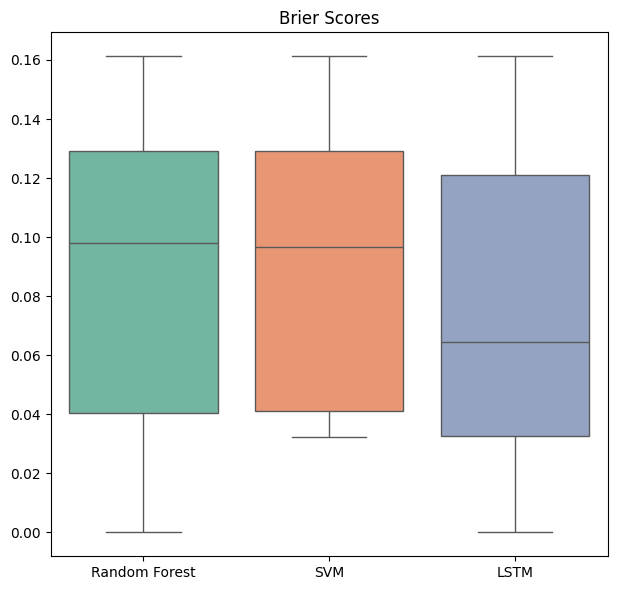

In [22]:
# Initialize KFold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store metrics
rf_metrics_list, svm_metrics_list, lstm_metrics_list = [], [], []
rf_brier_score, svm_brier_score, lstm_brier_score = [], [], []

# Cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print(f"\nFold {fold}:")

    # Ensure target_classes are not empty
    target_classes = y_train.dropna().unique()

    # Fill NaN values in y_train and y_test with random values from the target classes
    if target_classes.size == 0:
        target_classes = [0]  # Replace with a default value
    y_train = y_train.apply(lambda x: np.random.choice(target_classes) if pd.isnull(x) else x)
    y_test = y_test.apply(lambda x: np.random.choice(target_classes) if pd.isnull(x) else x)

    # Ensure no NaN values in the target columns
    print("Missing values in y_train:", y_train.isnull().sum())
    print("Missing values in y_test:", y_test.isnull().sum())

    # Random Forest
    rf_model = RandomForestClassifier(random_state=1)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_conf_matrix = confusion_matrix(y_test, rf_pred)
    rf_metrics = calculate_metrics(rf_conf_matrix)
    rf_metrics_list.append(rf_metrics)
    rf_brier_score.append(brier_score_loss(y_test, rf_pred))
    print(f"Random Forest Confusion Matrix:\n{rf_conf_matrix}")
    print(f"Random Forest Metrics: {rf_metrics}")

    # SVM
    svm_model = SVC(probability=True)
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)
    svm_conf_matrix = confusion_matrix(y_test, svm_pred)
    svm_metrics = calculate_metrics(svm_conf_matrix)
    svm_metrics_list.append(svm_metrics)
    svm_brier_score.append(brier_score_loss(y_test, svm_pred))
    print(f"SVM Confusion Matrix:\n{svm_conf_matrix}")
    print(f"SVM Metrics: {svm_metrics}")

    # LSTM
    lstm_model = build_lstm_model((X_train.shape[1], 1))
    X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
    lstm_pred = (lstm_model.predict(X_test_lstm) > 0.5).astype(int)
    lstm_conf_matrix = confusion_matrix(y_test, lstm_pred)
    lstm_metrics = calculate_metrics(lstm_conf_matrix)
    lstm_metrics_list.append(lstm_metrics)
    lstm_brier_score.append(brier_score_loss(y_test, lstm_pred))
    print(f"LSTM Confusion Matrix:\n{lstm_conf_matrix}")
    print(f"LSTM Metrics: {lstm_metrics}")

# Convert lists to DataFrame for better presentation
rf_metrics_df = pd.DataFrame(rf_metrics_list)
svm_metrics_df = pd.DataFrame(svm_metrics_list)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list)

# Calculate average metrics for each model
print("\nAverage Metrics for Random Forest:")
print(rf_metrics_df.mean())
print("\nAverage Metrics for SVM:")
print(svm_metrics_df.mean())
print("\nAverage Metrics for LSTM:")
print(lstm_metrics_df.mean())

# Visualize the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=[rf_brier_score, svm_brier_score, lstm_brier_score],
            ax=plt.gca(), palette='Set2')
plt.xticks([0, 1, 2], ['Random Forest', 'SVM', 'LSTM'])
plt.title('Brier Scores')
plt.tight_layout()
plt.show()

Comparison of average metrics:
                  Random Forest       SVM      LSTM
Sensitivity            0.968113  0.971561  0.978491
Specificity            0.554101  0.521561  0.575529
Accuracy               0.909462  0.906344  0.922473
Precision              0.932784  0.925674  0.935651
Recall                 0.968113  0.971561  0.978491
F1 Score               0.948479   0.94648  0.955505
Balanced Accuracy      0.762919  0.748565  0.777607
TSS                    0.525839  0.497131  0.555214
HSS                    0.480711  0.489243  0.544454
Brier Score                 NaN       NaN       NaN
Brier Skill Score           NaN       NaN       NaN

True Positive Rate (TPR) and False Positive Rate (FPR):
Random Forest - TPR: [0.         0.93103448 1.        ]
Random Forest - FPR: [0. 0. 1.]
SVM - TPR: [0.         0.96551724 1.        ]
SVM - FPR: [0. 0. 1.]
LSTM - TPR: [0.         0.96551724 1.        ]
LSTM - FPR: [0. 0. 1.]


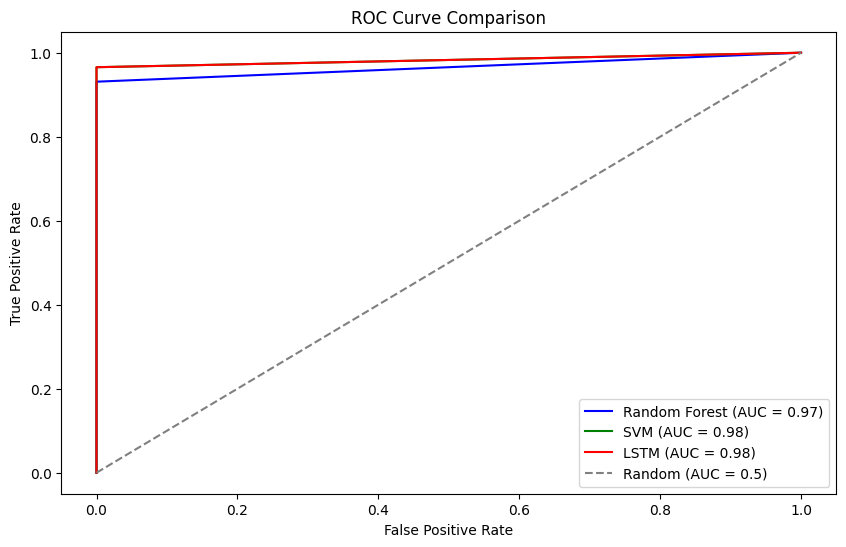


Average Brier Score - Random Forest: 0.0905
Average Brier Score - SVM: 0.0937
Average Brier Score - LSTM: 0.0775


In [24]:
# Convert the list of dictionaries into a DataFrame for each model
rf_metrics_df = pd.DataFrame(rf_metrics_list)
svm_metrics_df = pd.DataFrame(svm_metrics_list)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list)

# Calculate average metrics for each model
rf_avg_metrics = rf_metrics_df.mean()
svm_avg_metrics = svm_metrics_df.mean()
lstm_avg_metrics = lstm_metrics_df.mean()

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Random Forest': rf_avg_metrics,
    'SVM': svm_avg_metrics,
    'LSTM': lstm_avg_metrics
})

# Display the comparison table
print("Comparison of average metrics:")
print(comparison_df)

# ROC and AUC
plt.figure(figsize=(10, 6))

# Compute ROC curves for each model (using predicted probabilities for each model)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred)
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, lstm_pred)

# Calculate AUC
rf_roc_auc = auc(fpr_rf, tpr_rf)
svm_roc_auc = auc(fpr_svm, tpr_svm)
lstm_roc_auc = auc(fpr_lstm, tpr_lstm)

# Print TPR and FPR for each model
print("\nTrue Positive Rate (TPR) and False Positive Rate (FPR):")
print(f"Random Forest - TPR: {tpr_rf}")
print(f"Random Forest - FPR: {fpr_rf}")
print(f"SVM - TPR: {tpr_svm}")
print(f"SVM - FPR: {fpr_svm}")
print(f"LSTM - TPR: {tpr_lstm}")
print(f"LSTM - FPR: {fpr_lstm}")

# Plot ROC curves
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {np.mean(rf_roc_auc):.2f})', color='blue')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {np.mean(svm_roc_auc):.2f})', color='green')
plt.plot(fpr_lstm, tpr_lstm, label=f'LSTM (AUC = {np.mean(lstm_roc_auc):.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random (AUC = 0.5)', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

# Display Brier Scores
print(f"\nAverage Brier Score - Random Forest: {np.mean(rf_brier_score):.4f}")
print(f"Average Brier Score - SVM: {np.mean(svm_brier_score):.4f}")
print(f"Average Brier Score - LSTM: {np.mean(lstm_brier_score):.4f}")